## Philadelphia bike ridership analysis
Data collected from https://www.rideindego.com/about/data/ and https://www.ncei.noaa.gov/cdo-web/
Thanks to indego for having very nicely cleaned and organized data :)

In [357]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import seaborn as sns
from scipy import stats

Data cleaning and importing

In [250]:
#some of the bikeIDs are mess so lets at least start by reading them as a string
rider_dataQ1 = pd.read_csv('indego-trips-2024-q1.csv', parse_dates = ['start_time','end_time'], dtype = {'bike_id': 'str'}) 
rider_dataQ2 = pd.read_csv('indego-trips-2024-q2.csv', parse_dates = ['start_time','end_time'], dtype = {'bike_id': 'str'})
rider_dataQ3 = pd.read_csv('indego-trips-2024-q3.csv', parse_dates = ['start_time','end_time'], dtype = {'bike_id': 'str'})
rider_dataQ4 = pd.read_csv('indego-trips-2024-q4.csv', parse_dates = ['start_time','end_time'], dtype = {'bike_id': 'str'})
rider_data = pd.concat([rider_dataQ1, rider_dataQ2, rider_dataQ3, rider_dataQ4])


In [341]:
# lets add some helpful columns 
rider_data['month'] = rider_data.start_time.dt.month
rider_data['day_of_week'] = rider_data.start_time.dt.dayofweek
rider_data['day_of_year'] = rider_data.start_time.dt.day_of_year
rider_data['week'] = np.ceil(rider_data['day_of_year']/7)


## Q1: What days of the week/ time of year do people ride bikes more? 
There are definitely more riders in Philly than LA. First we see that people are WAY more likely to ride in the warmer months with 2x more riders in the summer than in the winter.


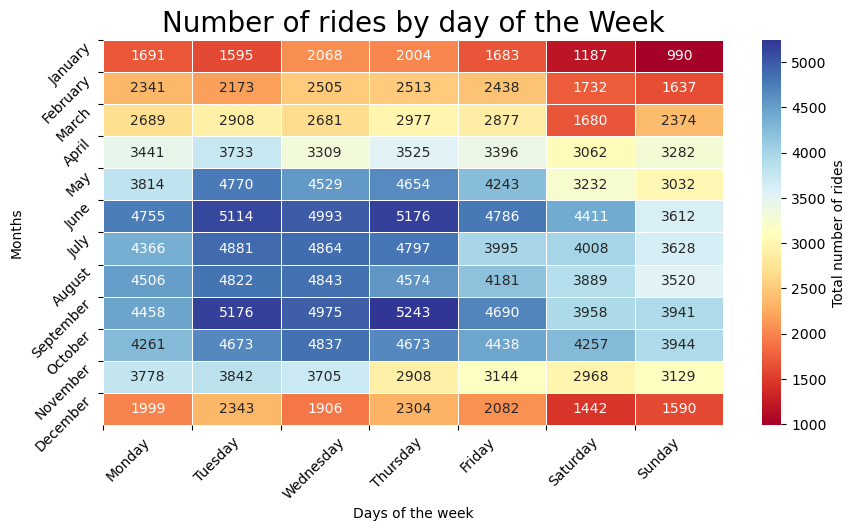

In [349]:
## I want to group by average ridership by day of the week/month of the year
days = rider_data.groupby(['month', 'day_of_week', 'day_of_year']).size().reset_index() # start by grouping by the month,day of week and day of year to get 366 rows
days.rename(columns= {0:'NumDays'}, inplace=True) #switch the empty column names to NumDays
#print(days_in_days.columns)


days_df = pd.pivot_table(days, index = 'month', values = 'NumDays' ,columns = 'day_of_week', aggfunc = 'mean').round() # now lets make a pivot table of them averaging by the mean

# draw the plots
f, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(days_df, annot=True, fmt="n", linewidths=.5, ax=ax,cmap="RdYlBu", cbar_kws={'label': 'Total number of rides'})

#draw on title, labels, and replace ticks with days/months
plt.title('Number of rides by day of the Week', fontsize = 20)
plt.xlabel('Days of the week')
plt.ylabel('Months')
plt.xticks(np.arange(7), ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],
           horizontalalignment = 'left', rotation = 45)
plt.yticks(np.arange(12), ['January','February','March','April','May','June','July','August','September','October', 'November', 'December'],
           verticalalignment = 'top', rotation = 45)
plt.show()

In [378]:
# are weekends different than weekdays?
days['weekend'] = days['day_of_week'].isin([5,6]) # split the table by weekdays and weekends

# oh no weekends are NOT normal but weekdays are normal
print(stats.shapiro(days[days['weekend']].NumDays))  # not normal
print(stats.shapiro(days[~days['weekend']].NumDays)) # normal

# so we will do a non-parametric comparison for different sized samples 
sta, pval = stats.mannwhitneyu(days[days['weekend']].NumDays,days[~days['weekend']].NumDays)
print(pval)
print('With a pval less than p<0.05, there is a statistically significant increase in the number of rides on the weekdays compared to weekends')

ShapiroResult(statistic=0.9428778339808311, pvalue=0.00021497980852288546)
ShapiroResult(statistic=0.9250034271266904, pvalue=3.141567446712172e-10)
1.6243774111037769e-07
With a pval less than p<0.05, there is a statistically significant increase in the number of rides on the weekdays compared to weekends


## Q2: Do people ride more electric vs standard bikes on different days/time of the year
In Philly, people ride electric more than standard across the board, however the difference is not consistent. Looking at the line plot below, even when people are riding more standard bikes in the warmer weather, they is an even bigger increase in the number of riders of electric bikes. I hypothesize this is because there are some people who would ride standard bikes when its warm and electric when its cold and then some people who will ride only electric bikes when its hot. Therefore there is a unique set of people who are 'fair weather electric bikers'. With a more complete dataset which has rider_ids I could test this more formally. 

In [383]:
riders_df = rider_data.groupby(['month', 'day_of_week', 'day_of_year', 'bike_type']).size().reset_index() # group the data similiarly to before
riders_df.rename(columns= {0:'NumDays'}, inplace=True)

riders = pd.pivot_table(riders_df, index = 'month', values = 'NumDays' ,columns = ['bike_type', 'day_of_week'], aggfunc = 'mean').round() # just add a new column for bike type

compared = riders['electric']- riders['standard'] # find the difference


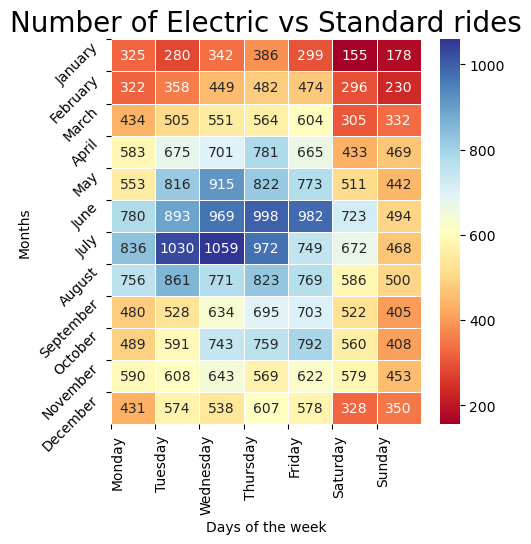

In [322]:
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(compared, annot=True, fmt="n", linewidths=.5, ax=ax,cmap="RdYlBu")

plt.title('Number of Electric vs Standard rides', fontsize = 20)
plt.xlabel('Days of the week')
plt.ylabel('Months')
plt.xticks(np.arange(7), ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],
           horizontalalignment = 'left', rotation = 90)
plt.yticks(np.arange(12), ['January','February','March','April','May','June','July','August','September','October', 'November', 'December'],
           verticalalignment = 'top', rotation = 45)
plt.show()

### Shown in another view ###

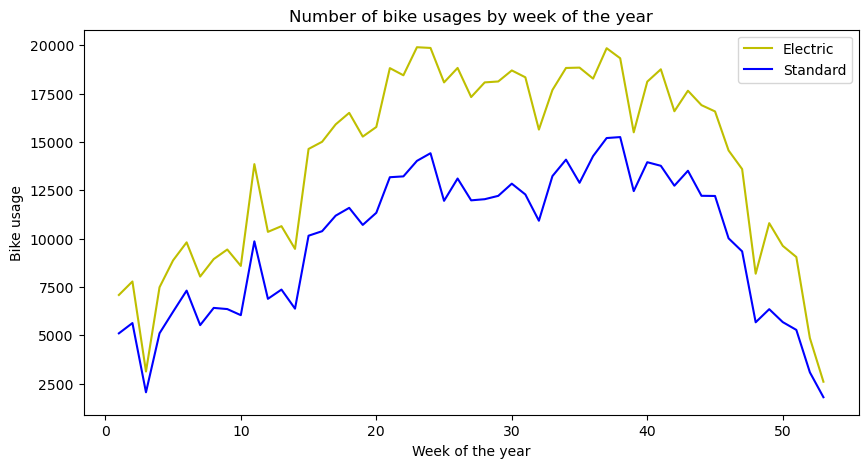

In [394]:
weekly_rider_df = pd.pivot_table(rider_data, index = 'week', values = 'trip_id',columns = 'bike_type', aggfunc = 'count')
weekly_rider_df.head()
fig, ax = plt.subplots(figsize=(10, 5))

# red dashes, blue squares and green triangles
ax.plot(weekly_rider_df.index, weekly_rider_df['electric'] , 'y-', weekly_rider_df.index, weekly_rider_df['standard'], 'b-')
ax.set_title('Number of bike usages by week of the year')
ax.legend(['Electric','Standard'])
ax.set_ylabel('Bike usage')
ax.set_xlabel('Week of the year')
plt.show()

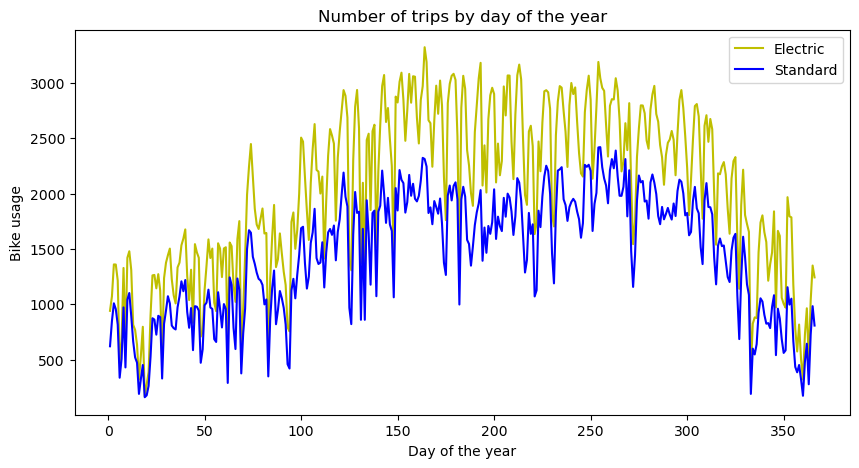

In [402]:
daily_rider_df = pd.pivot_table(rider_data, index = 'day_of_year', values = 'trip_id',columns = 'bike_type', aggfunc = 'count')
fig, ax = plt.subplots(figsize=(10, 5))
#ax.bar(weekly_rider_pt.index,weekly_rider_pt['electric'])

# red dashes, blue squares and green triangles
plt.plot(daily_rider_df.index, daily_rider_df['electric'] , 'y-', daily_rider_df.index, daily_rider_df['standard'], 'b-')
ax.legend(['Electric','Standard'])
ax.set_ylabel('Bike usage')
ax.set_xlabel('Day of the year')
ax.set_title('Number of trips by day of the year')

plt.show()

## Q3: How does weather affect bike usage? Let's combine it with weather data from the Philadelphia Airport
Looking at the correlations between bike usage and the weather we see a striking correlation between the temperature and the use of standard and electric bikes (r = .76 and .79!). This is even higher than in LA for standard bikes. I'm making a guess that the low variance in the temperature in LA is interfering with the correlation. The effect of precipitation is quite similiar to LA (LA: r= -.38 standard and r=-.39 electric compared to Philly: r=-.35 standard and r=-.33 electric) I'd be curious if the correlation is consistent with other cities as well. I would also think that truly these are non-linear trends so in a more complete analysis I could look a little differently given that I suspect a parabolic relationship to temperature and ridership.

In [270]:
## way more columns that I want so I'm just going to specify what I want here
onlycols = ['DATE','REPORT_TYPE','HourlyDewPointTemperature','HourlyDryBulbTemperature','HourlyPrecipitation','HourlyRelativeHumidity', 'Sunrise','Sunset',
         'DailyAverageDewPointTemperature','DailyAverageDryBulbTemperature','DailyAverageRelativeHumidity','DailyAverageWetBulbTemperature', 'DailyPrecipitation']
weather_df = pd.read_csv('weather_philly_2024.csv', usecols = onlycols, low_memory=False,parse_dates = ['DATE'])

In [336]:
#subset the data by only including the daily reports and do some cleaning
daily_df = weather_df[~weather_df['Sunrise'].isna()]
daily_df = daily_df[['DATE', 'Sunrise','Sunset','DailyAverageDryBulbTemperature', 'DailyPrecipitation']]
# Daily precipitation and DryBulb are strings and need to become numbers so I'm going to clean up the few strings that are interfering
daily_df.loc[daily_df['DailyPrecipitation'].isin(['0.00s', 'T']), 'DailyPrecipitation'] = 0 # s
daily_df['DailyPrecipitation']  = daily_df['DailyPrecipitation'].astype('float') # make them floats

daily_df.loc[daily_df['DailyAverageDryBulbTemperature'].isin(['61s','69s']), 'DailyAverageDryBulbTemperature'] = 61
daily_df['DailyAverageDryBulbTemperature']  = daily_df['DailyAverageDryBulbTemperature'].astype('float') # make them floats

daily_df.reset_index(inplace= True) # reset the index
daily_df.index += 1




In [274]:
eachday_df = pd.concat([daily_rider_df, daily_df], axis=1)
eachday_df[['DailyPrecipitation','DailyAverageDryBulbTemperature','standard','electric']].corr()


,DailyPrecipitation,DailyAverageDryBulbTemperature,standard,electric
DailyPrecipitation,1.000000,-0.062644,-0.353542,-0.330163
DailyAverageDryBulbTemperature,-0.062644,1.000000,0.763450,0.792597
standard,-0.353542,0.763450,1.000000,0.972726
electric,-0.330163,0.792597,0.972726,1.000000


This correlation suggests that when there is more rain, there is less riders for both standard and electric bikes. However, when while nicer temperatures lead to higher standard bike users there is no effect on electric bikes users. 

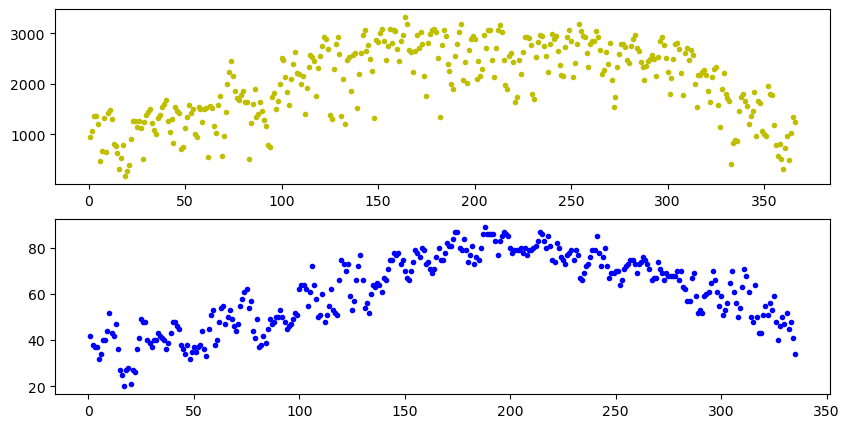

In [334]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10, 5))
#ax.bar(weekly_rider_pt.index,weekly_rider_pt['electric'])

# red dashes, blue squares and green triangles
ax1.plot(eachday_df.index, eachday_df['electric'] , 'y.')
ax2.plot(eachday_df.index, eachday_df['DailyAverageDryBulbTemperature'], 'b.')
plt.show()

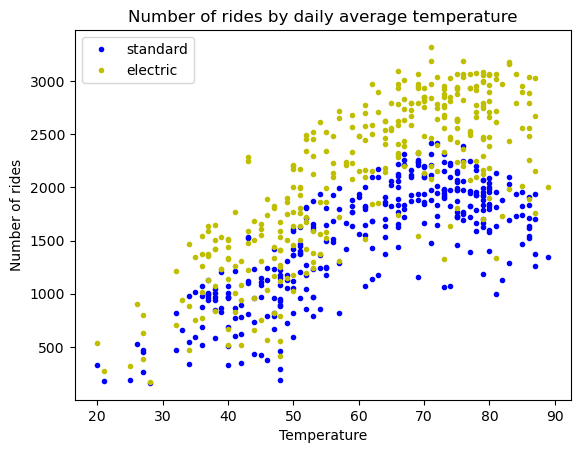

In [436]:
fig, ax = plt.subplots()

ax = plt.plot(eachday_df['DailyAverageDryBulbTemperature'] ,eachday_df['standard'],  'b.', eachday_df['DailyAverageDryBulbTemperature'] , eachday_df['electric'],'y.')
plt.ylabel('Number of rides')
plt.xlabel('Temperature')
plt.title('Number of rides by daily average temperature')
plt.legend(['standard','electric'])
plt.show()

## Q4: Where are people biking?
Most people are using the bikes for one-way trips (94%!). This might be because they are actually doing round trips but they are locking up the bikes between so each ride is one-way. There seems to be a few stations that get a TON of traffic with other stations getting different amounts. The starting stations and ending stations make very similiarly which is what you'd expect given that there needs to be bikes left to get picked up.

In [444]:
# let's get back to some rider data
rider_data.head()
# What is the duration of one-way verse round trip
ow_count = rider_data[rider_data['trip_route_category'] == 'One Way'].shape[0]
rt_count = rider_data[rider_data['trip_route_category'] == 'Round Trip'].shape[0]

ow_rate = round(ow_count/rider_data['trip_route_category'].shape[0]*100,1)
rt_rate = round(rt_count/rider_data['trip_route_category'].shape[0]*100,1)
print('One way rate:', ow_rate, '%', 'Round trip rate: ',rt_rate, '%')


One way rate: 93.6 % Round trip rate:  6.4 %


Let's plot a random sample of the lat and long of the people. In a more complete analysis I would think to overlap this with the map and look closer into route that people are taking at different times. I'd also probably want information about how many bikes are currently in/out of any given station. Then you could assess under/over utilization of different stations.

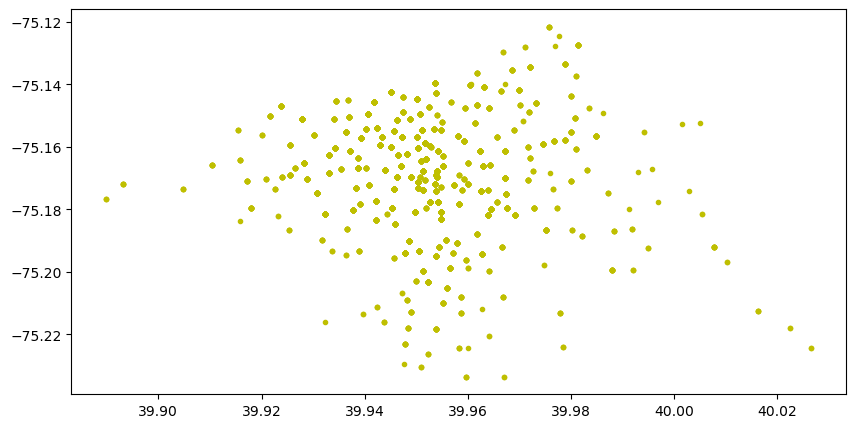

In [455]:
shuffOrd = np.random.permutation(rider_data.index)
subset = shuffOrd[0:1000]

fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(rider_data['start_lat'][subset], rider_data['start_lon'][subset] , 'y.')
plt.show()

Let's see if certain stations are more likely to be riden between

<Axes: xlabel='end_station', ylabel='start_station'>

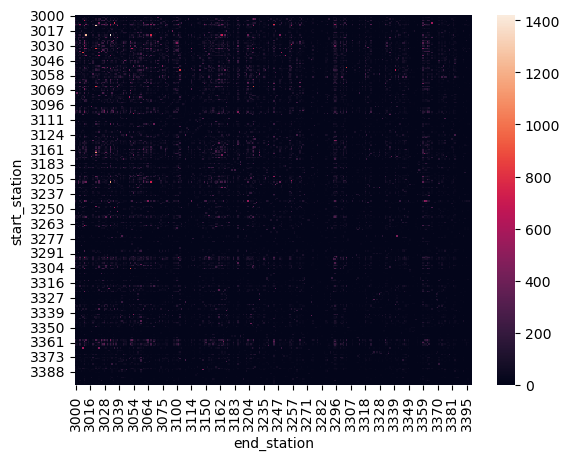

In [284]:
one_way_trips = pd.pivot_table(rider_data[rider_data['trip_route_category'] == 'One Way'], index = 'start_station', values = 'trip_id',columns = 'end_station', aggfunc = 'count').fillna(0)
sns.heatmap(one_way_trips)


In [470]:
st = []
en = []

for i in one_way_trips.index:
    if one_way_trips.loc[i].sum() > 5000:
        en.append(i)

for i in one_way_trips.columns:
    if one_way_trips[i].sum() > 5000:
        st.append(i)       

<Axes: xlabel='end_station', ylabel='start_station'>

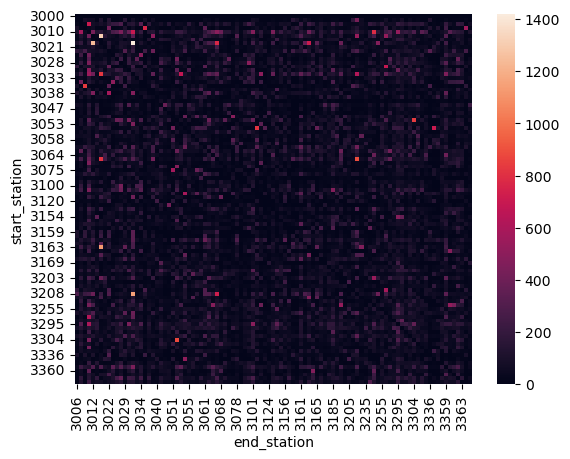

In [472]:
sns.heatmap(one_way_trips.loc[st, en])

Compared to LA there are way more mixing of stations in philly. There are not particular hotshops where only two or three stations connect.

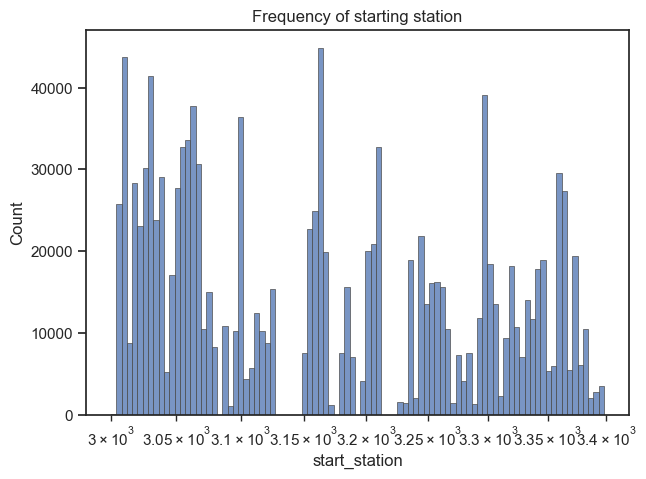

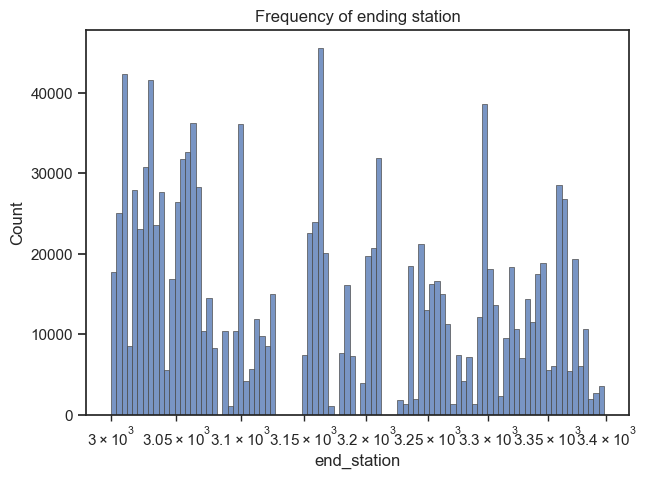

In [479]:
sns.set_theme(style="ticks")


fig1, ax1 = plt.subplots(figsize=(7, 5))
sns.despine(f)

ax1 = sns.histplot(
    rider_data,
    x="start_station",
    edgecolor=".3",
    linewidth=.5,
    log_scale=True,
)

ax1.set_title('Frequency of starting station')
#ax.set_xticks([500, 1000, 2000, 5000, 10000])

fig2, ax2 = plt.subplots(figsize=(7, 5))
sns.despine(f)

ax2 = sns.histplot(
    rider_data,
    x="end_station",
    edgecolor=".3",
    linewidth=.5,
    log_scale=True,
)
ax2.set_title('Frequency of ending station')
plt.show()

There is way more of a distribution of philly stations than LA stations! with most stations getting uses a decent amount of time throughout.

## Future directions:
#### 1. Are there specific types of riders? How does their ridership change throughout the year?
#### 2. Are there locations that are underutilized? Would adding more bikes increase ridership in this area?
#### 3. What other things besides weather might be impacting ridership?
#### 4. Why is ridership higher in philly even though LA has better weather?
#### 5. Are there certain 'commuter lanes' in Philly? 
#### 6. How can you increase ridership in LA?